#### **Reporte Caso 3** ####
#### **Optimización de Transporte con Penalización No Lineal** ####
#### **Asignatura:** Programación para Analítica Prescriptiva y de Apoyo a la Decisión ####
#### **Instructor:** Dr. Josué Domínguez Guerrero ####
#### **Alumno:** Aminadab Córdova Acosta ####

**1. Definición del problema**

En las operaciones logísticas modernas, uno de los desafíos clave consiste en distribuir productos desde centros de distribución o almacenes hacia múltiples destinos de forma eficiente.  
Tradicionalmente, los modelos de transporte utilizan costos lineales por unidad transportada; sin embargo, esta aproximación puede ser poco realista en entornos con restricciones físicas, tráfico, desgaste o penalizaciones por sobreuso de rutas.

En este ejercicio, abordamos un problema de transporte desde dos almacenes hacia tres destinos, incorporando una penalización no lineal en el costo, proporcional al cuadrado de la cantidad enviada en cada ruta. Este enfoque permite modelar el impacto de congestión, incremento en consumo de combustible, mantenimiento adicional o pérdida de eficiencia logística.

El objetivo es encontrar la asignación óptima de envíos entre almacenes y destinos para satisfacer la demanda, sin sobrepasar la capacidad de los almacenes, y minimizando el costo total de transporte.



Se busca distribuir productos desde **dos almacenes** hacia **tres destinos**, minimizando el **costo total de transporte**. El costo incluye una **tarifa base** y una **penalización cuadrática** por congestión o sobreuso de ruta.

---

Datos del problema

Almacenes y capacidades

- Almacén A1: capacidad máxima de 100 unidades  
- Almacén A2: capacidad máxima de 120 unidades

Destinos y demandas

- Destino D1: demanda de 80 unidades  
- Destino D2: demanda de 70 unidades  
- Destino D3: demanda de 60 unidades

Costos por unidad enviada (tarifa base + penalización cuadrática):

$$
\begin{aligned}
c_{11}(x) &= 4 + 0.01 x_{11}^2 \\
c_{12}(x) &= 6 + 0.015 x_{12}^2 \\
c_{13}(x) &= 9 + 0.02 x_{13}^2 \\
c_{21}(x) &= 5 + 0.012 x_{21}^2 \\
c_{22}(x) &= 4 + 0.018 x_{22}^2 \\
c_{23}(x) &= 7 + 0.01 x_{23}^2 \\
\end{aligned}
$$

---
**2. Modelo matemático**

Variables de decisión

- $x_{ij}$: cantidad enviada del almacén $i$ al destino $j$, para $i \in \{1,2\}$ y $j \in \{1,2,3\}$

---

Función Objetivo

Minimizar el costo total de transporte:

$$
\min \sum_{i=1}^{2} \sum_{j=1}^{3} x_{ij} \cdot \left(c_{ij}^{\text{base}} + \alpha_{ij} \cdot x_{ij}^2 \right)
$$

---

Restricciones

1. Capacidad de los almacenes:

$$
x_{11} + x_{12} + x_{13} \leq 100 \\
x_{21} + x_{22} + x_{23} \leq 120
$$

2. Satisfacción de demanda:

$$
x_{11} + x_{21} = 80 \\
x_{12} + x_{22} = 70 \\
x_{13} + x_{23} = 60
$$

3. No negatividad:

$$
x_{ij} \geq 0 \quad \forall i,j
$$

---

**3. Implementación en Pyomo**

In [1]:
from pyomo.environ import *
from pyomo.opt import SolverFactory

model = ConcreteModel()

# Índices
origenes = [1, 2]
destinos = [1, 2, 3]
model.I = Set(initialize=origenes)
model.J = Set(initialize=destinos)

# Parámetros de costo base y penalización cuadrática
costos_base = {
    (1,1): 4, (1,2): 6, (1,3): 9,
    (2,1): 5, (2,2): 4, (2,3): 7
}
penalizacion = {
    (1,1): 0.01, (1,2): 0.015, (1,3): 0.02,
    (2,1): 0.012, (2,2): 0.018, (2,3): 0.01
}

# Variables de envío
model.x = Var(model.I, model.J, domain=NonNegativeReals)

# Función objetivo no lineal
def obj_rule(m):
    return sum(m.x[i,j] * (costos_base[i,j] + penalizacion[i,j] * m.x[i,j]**2)
               for i in m.I for j in m.J)
model.obj = Objective(rule=obj_rule, sense=minimize)

# Restricciones de capacidad de los almacenes
model.capacidad_A1 = Constraint(expr=sum(model.x[1,j] for j in model.J) <= 100)
model.capacidad_A2 = Constraint(expr=sum(model.x[2,j] for j in model.J) <= 120)

# Restricciones de demanda
model.demanda_D1 = Constraint(expr=model.x[1,1] + model.x[2,1] == 80)
model.demanda_D2 = Constraint(expr=model.x[1,2] + model.x[2,2] == 70)
model.demanda_D3 = Constraint(expr=model.x[1,3] + model.x[2,3] == 60)

# Resolver con IPOPT
solver = SolverFactory('ipopt')
results = solver.solve(model, tee=True)

# Resultados
for i in model.I:
    for j in model.J:
        print(f"x[{i},{j}] = {value(model.x[i,j]):.2f}")

print("Costo total: ", value(model.obj))

Ipopt 3.12.13: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.13, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        6
Number of nonzeros in inequality constraint Jacobian.:        6
Number of nonzeros in Lagrangian Hessian.............:        6

Total number of variables............................:        6
                     variables with only lower bounds:        6
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Tot

**4. Interpretación de la decisión preescrita por el modelo de decisión**

El modelo asigna los envíos desde ambos almacenes a todos los destinos de manera eficiente, utilizando toda la capacidad de A1 y parte de A2 para satisfacer la demanda total. La solución minimiza el costo total de transporte, $4734.07, teniendo en cuenta tanto los costos base como las penalizaciones por envío elevado en cada ruta, lo que permite evitar sobrecargas y distribuir los envíos estratégicamente.

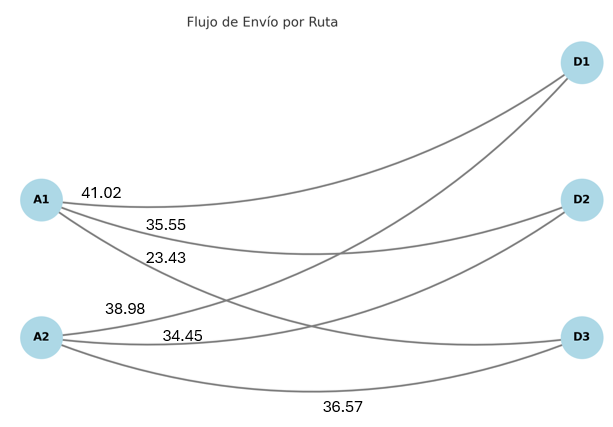